Nombre del equipo: Manchester United Football Club y su id: 985 


Predicciones para los partidos de Manchester United Football Club a partir de la jornada 28:
Partido 1: Resultado predicho: Manchester United Football Club gana como visitante
Partido 2: Resultado predicho: Manchester United Football Club pierde como visitante
Partido 3: Resultado predicho: Manchester United Football Club gana como local
Partido 4: Resultado predicho: Manchester United Football Club gana como visitante
Partido 5: Resultado predicho: Manchester United Football Club gana como local
Partido 6: Resultado predicho: Manchester United Football Club pierde como visitante
Partido 7: Resultado predicho: Manchester United Football Club empata como local
Partido 8: Resultado predicho: Manchester United Football Club gana como visitante
Partido 9: Resultado predicho: Manchester United Football Club gana como local
Partido 10: Resultado predicho: Manchester United Football Club gana como visitante
Partido 11: Resulta

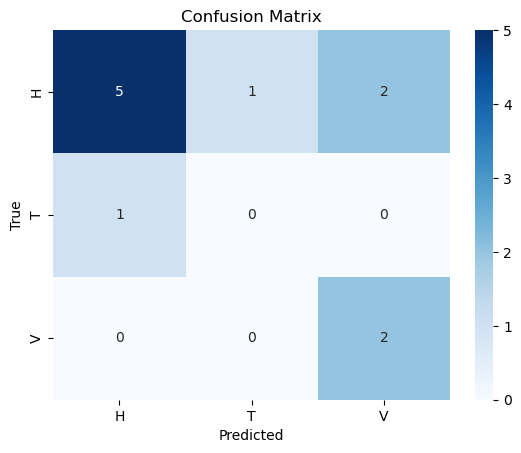

                                Feature  Importance
3   home_club_position_label_Relegation    0.142629
5       away_club_position_label_Europe    0.121606
15              attendance_label_Medium    0.104454
14               attendance_label_Large    0.103588
1       home_club_position_label_Europe    0.101583
2      home_club_position_label_Nothing    0.064377
7   away_club_position_label_Relegation    0.057237
18                         hosting_Home    0.047433
17                         hosting_Away    0.046562
11        away_club_formation_label_3_D    0.038019


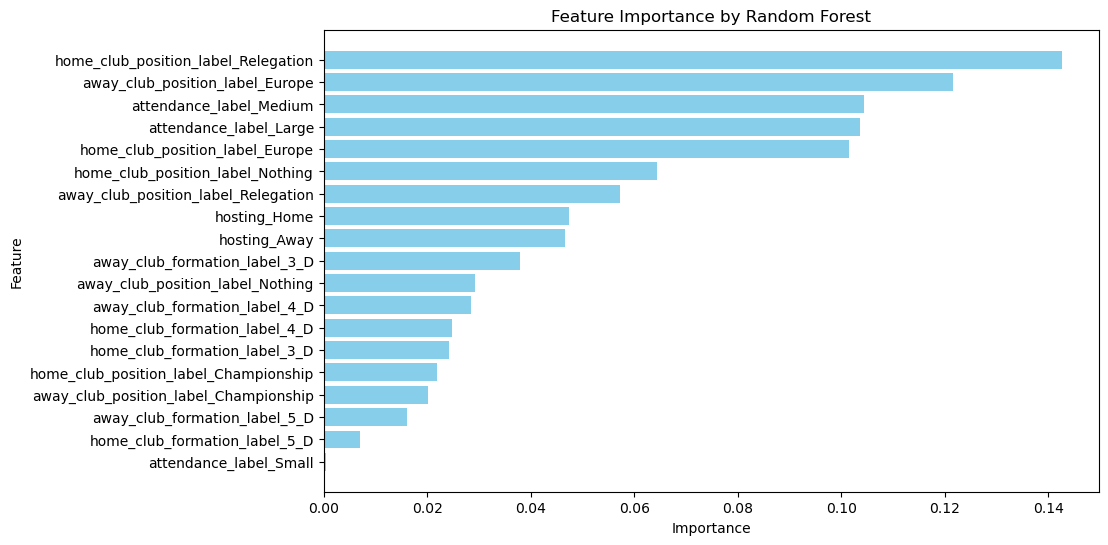

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

def assign_attendance_label(attendance):
    if attendance > 45000:  
        return 'Large'
    elif 20000 <= attendance < 45000: 
        return 'Medium'
    elif attendance < 20000:  
        return 'Small'
    else:
        return None

def assign_formation_label(formation):
    if formation.startswith('4'):   
        return '4_D'
    elif formation.startswith('3'): 
        return '3_D'
    elif formation.startswith('5'): 
        return '5_D'
    else:
        return None

def assign_position_label(position):
    if position <= 2:
        return 'Championship'
    elif 3 <= position <= 9:
        return 'Europe'
    elif 10 <= position <= 14:
        return 'Nothing'
    elif 15 <= position <= 20:
        return 'Relegation'
    else:
        return None


club_data = pd.read_csv('csv/clubs.csv')
club_games_data = pd.read_csv('csv/club_games.csv')
games_data = pd.read_csv('csv/games.csv')
games_data['home_club_formation'] = games_data['home_club_formation'].str.replace(r'^\D+', '', regex=True)
games_data['away_club_formation'] = games_data['away_club_formation'].str.replace(r'^\D+', '', regex=True)


season = int(input("Ingresa la temporada a buscar (2023 para la 23/24, 2022 para 22/23): "))
matchDay = 28 

filtered_games = games_data[(games_data['season'] == season) & 
                            (games_data['competition_id'] == 'GB1') & 
                            (games_data['competition_type'] == 'domestic_league')].copy()

filtered_games['round'] = filtered_games['round'].str.replace(r'\D+', '', regex=True).astype(int)
selected_games = filtered_games[filtered_games['round'] == matchDay]

filtered_teams = pd.DataFrame({
    'club_names': pd.concat([filtered_games['home_club_name'], filtered_games['away_club_name']], ignore_index=True)
}).drop_duplicates(subset='club_names', keep='first')

selected_index = int(input("Ingresa el índice del equipo que deseas seleccionar: "))
selected_team = filtered_teams.loc[selected_index]

if not selected_team.empty:
    team_name = selected_team['club_names']
    team_id = filtered_games.loc[filtered_games['home_club_name'] == team_name, 'home_club_id'].drop_duplicates(keep='first').iloc[0]
    print(f"Nombre del equipo: {team_name} y su id: {team_id} \n")
else:
    print("No se encontró un equipo con el índice proporcionado.\n")


filtered_games['result'] = filtered_games.apply(lambda row: 'H' if row['home_club_goals'] > row['away_club_goals'] else 
                                                ('T' if row['home_club_goals'] == row['away_club_goals'] else 'V'), axis=1)

filtered_games['home_club_position_label'] = filtered_games['home_club_position'].apply(assign_position_label)
filtered_games['away_club_position_label'] = filtered_games['away_club_position'].apply(assign_position_label)
filtered_games['home_club_formation_label'] = filtered_games['home_club_formation'].apply(assign_formation_label)
filtered_games['away_club_formation_label'] = filtered_games['away_club_formation'].apply(assign_formation_label)
filtered_games['attendance_label'] = filtered_games['attendance'].apply(assign_attendance_label)


team_home_games = filtered_games[filtered_games['home_club_name'] == team_name].merge(
    club_games_data[(club_games_data['hosting'] == 'Home') & (club_games_data['club_id'] == team_id)],
    on='game_id', how='inner')

team_away_games = filtered_games[filtered_games['away_club_name'] == team_name].merge(
    club_games_data[(club_games_data['hosting'] == 'Away') & (club_games_data['club_id'] == team_id)],
    on='game_id', how='inner')

columns_to_keep = ['game_id', 'home_club_name', 'away_club_name', 'home_club_id', 'away_club_id', 'round', 'attendance_label',
                   'home_club_position_label', 'away_club_position_label', 'home_club_formation_label', 'away_club_formation_label',
                   'home_club_goals', 'away_club_goals', 'hosting', 'is_win', 'result']

team_home_games = team_home_games[columns_to_keep]
team_away_games = team_away_games[columns_to_keep]
filtered_games = pd.concat([team_home_games, team_away_games])

filtered_games = filtered_games.sort_values(by='round').reset_index(drop=True)


features = ['home_club_position_label', 'away_club_position_label', 'home_club_formation_label', 
            'away_club_formation_label', 'attendance_label', 'hosting']

train_data = filtered_games[filtered_games['round'] < matchDay]
X_train = train_data[features]
y_train = train_data['result']


encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
X_train_encoded = encoder.fit_transform(X_train)

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

model = GridSearchCV(RandomForestClassifier(class_weight='balanced', random_state=42), param_grid, cv=5, scoring='accuracy')
model.fit(X_train_encoded, y_train)
best_model = model.best_estimator_
print("Mejores hiperparámetros encontrados:", model.best_params_)


test_data = filtered_games[((filtered_games['home_club_id'] == team_id) | (filtered_games['away_club_id'] == team_id)) & 
                           (filtered_games['round'] >= matchDay)][features]
test_data_result = filtered_games[((filtered_games['home_club_id'] == team_id) | (filtered_games['away_club_id'] == team_id)) & 
                                   (filtered_games['round'] >= matchDay)]['result']
X_test_encoded = encoder.transform(test_data)

if not test_data.empty:
    y_pred = best_model.predict(X_test_encoded)
    y_test = test_data_result.values

    print(f"\nPredicciones para los partidos de {team_name} a partir de la jornada {matchDay}:")
    for idx, pred in enumerate(y_pred):
        row = test_data.iloc[idx]
        if row['hosting'] == 'Home':
            if pred == 'H':
                print(f"Partido {idx + 1}: Resultado predicho: {team_name} gana como local")
            elif pred == 'V':
                print(f"Partido {idx + 1}: Resultado predicho: {team_name} pierde como local")
            else:
                print(f"Partido {idx + 1}: Resultado predicho: {team_name} empata como local")    
        elif row['hosting'] == 'Away':
            if pred == 'H':
                print(f"Partido {idx + 1}: Resultado predicho: {team_name} pierde como visitante")
            elif pred == 'V':
                print(f"Partido {idx + 1}: Resultado predicho: {team_name} gana como visitante")
            else:
                print(f"Partido {idx + 1}: Resultado predicho: {team_name} empata como visitante")    
        else: 
            print('Fallo en la detección del local')


    print("\nValores predichos en el conjunto de prueba (y_pred):")
    print(pd.DataFrame(y_pred, columns=['y_pred']))

    print("\nValores verdaderos en el conjunto de prueba (y_test):")
    print(pd.DataFrame(y_test, columns=['y_test']))

   
    print("\nReporte de Clasificación en el conjunto de prueba:")
    print(classification_report(y_test, y_pred))

    print("\nPrecisión en el conjunto de prueba:")
    print(f"Accuracy en prueba: {accuracy_score(y_test, y_pred):.2f}")

  
    cm = confusion_matrix(y_test, y_pred, labels=best_model.classes_)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=best_model.classes_, yticklabels=best_model.classes_)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

   
    feature_names = encoder.get_feature_names_out(X_train.columns)
    importances = best_model.feature_importances_
    feature_importance = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    }).sort_values(by='Importance', ascending=False)

    print(feature_importance.head(10))
    plt.figure(figsize=(10, 6))
    plt.barh(feature_importance['Feature'], feature_importance['Importance'], color='skyblue')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.title('Feature Importance by Random Forest')
    plt.gca().invert_yaxis()  
    plt.show()

else:
    print(f"No hay partidos disponibles para {team_name} a partir de la jornada {matchDay}")


Nombre del equipo: Manchester United Football Club y su id: 985 

Mejores hiperparámetros encontrados: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 200}

Predicciones para los partidos de Manchester United Football Club de la temporada 2022:
Partido 1: Resultado predicho: Manchester United Football Club empata como local
Partido 2: Resultado predicho: Manchester United Football Club pierde como visitante
Partido 3: Resultado predicho: Manchester United Football Club gana como local
Partido 4: Resultado predicho: Manchester United Football Club empata como visitante
Partido 5: Resultado predicho: Manchester United Football Club gana como visitante
Partido 6: Resultado predicho: Manchester United Football Club pierde como local
Partido 7: Resultado predicho: Manchester United Football Club empata como visitante
Partido 8: Resultado predicho: Manchester United Football Club gana como local
Partido 9: Resultado predicho: Manchester United Football Club 

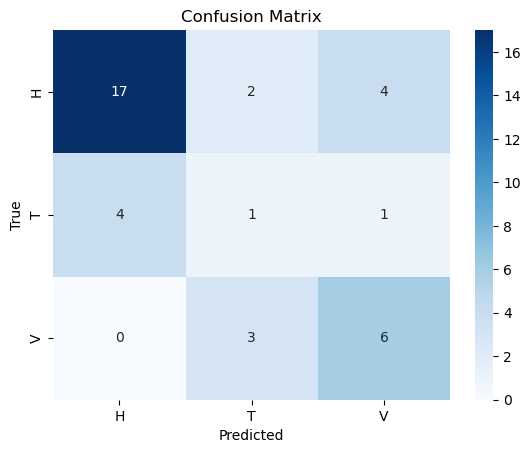

                                  Feature  Importance
7     away_club_position_label_Relegation    0.098057
0   home_club_position_label_Championship    0.093118
3     home_club_position_label_Relegation    0.090661
4   away_club_position_label_Championship    0.083274
5         away_club_position_label_Europe    0.059134
1         home_club_position_label_Europe    0.054311
15                attendance_label_Medium    0.049766
14                 attendance_label_Large    0.049497
12          away_club_formation_label_4_D    0.046515
17                  attendance_label_None    0.045994


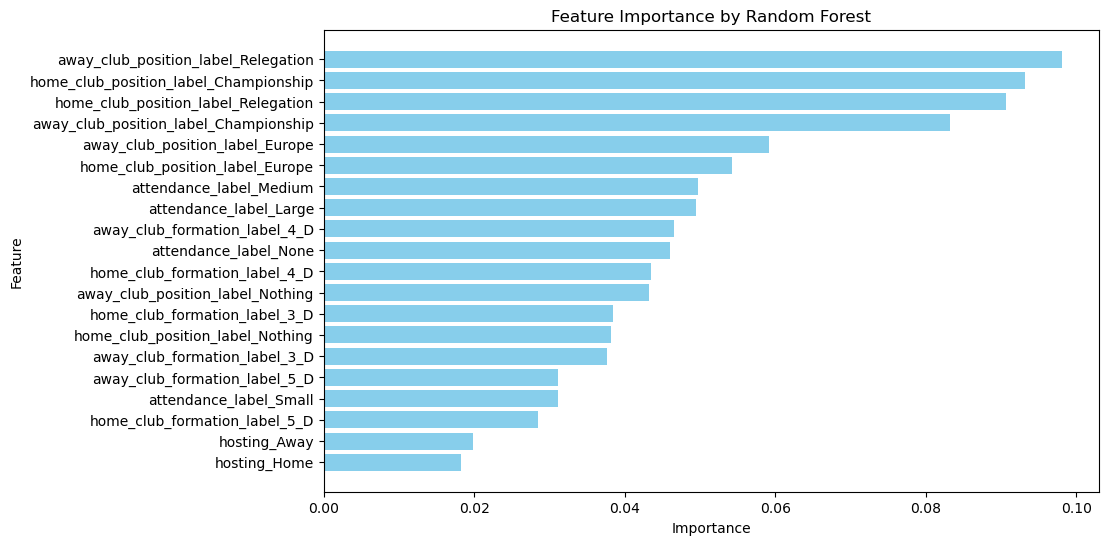

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score


def assign_attendance_label(attendance):
    if attendance > 45000:  
        return 'Large'
    elif 20000 <= attendance < 45000:  
        return 'Medium'
    elif attendance < 20000: 
        return 'Small'
    else:
        return None

def assign_formation_label(formation):
    if formation.startswith('4'):  
        return '4_D'
    elif formation.startswith('3'): 
        return '3_D'
    elif formation.startswith('5'):  
        return '5_D'
    else:
        return None

def assign_position_label(position):
    if position <= 2:
        return 'Championship'
    elif 3 <= position <= 9:
        return 'Europe'
    elif 10 <= position <= 14:
        return 'Nothing'
    elif 15 <= position <= 20:
        return 'Relegation'
    else:
        return None


club_data = pd.read_csv('csv/clubs.csv')
club_games_data = pd.read_csv('csv/club_games.csv')
games_data = pd.read_csv('csv/games.csv')
games_data['home_club_formation'] = games_data['home_club_formation'].str.replace(r'^\D+', '', regex=True)
games_data['away_club_formation'] = games_data['away_club_formation'].str.replace(r'^\D+', '', regex=True)



season = int(input("Ingresa la temporada a buscar (2023 para la 23/24, 2022 para 22/23): "))
 

filtered_games = games_data[(games_data['season'] >= 2019) & 
                            (games_data['competition_id'] == 'GB1') & 
                            (games_data['competition_type'] == 'domestic_league')].copy()

filtered_games['round'] = filtered_games['round'].str.replace(r'\D+', '', regex=True).astype(int)
selected_games = filtered_games[filtered_games['season'] == season]

filtered_teams = pd.DataFrame({
    'club_names': pd.concat([selected_games['home_club_name'], selected_games['away_club_name']], ignore_index=True)
}).drop_duplicates(subset='club_names', keep='first')

selected_index = int(input("Ingresa el índice del equipo que deseas seleccionar: "))
selected_team = filtered_teams.loc[selected_index]

if not selected_team.empty:
    team_name = selected_team['club_names']
    team_id = selected_games.loc[selected_games['home_club_name'] == team_name, 'home_club_id'].drop_duplicates(keep='first').iloc[0]
    print(f"Nombre del equipo: {team_name} y su id: {team_id} \n")
else:
    print("No se encontró un equipo con el índice proporcionado.\n")


filtered_games['result'] = filtered_games.apply(lambda row: 'H' if row['home_club_goals'] > row['away_club_goals'] else 
                                                ('T' if row['home_club_goals'] == row['away_club_goals'] else 'V'), axis=1)

filtered_games['home_club_position_label'] = filtered_games['home_club_position'].apply(assign_position_label)
filtered_games['away_club_position_label'] = filtered_games['away_club_position'].apply(assign_position_label)
filtered_games['home_club_formation_label'] = filtered_games['home_club_formation'].apply(assign_formation_label)
filtered_games['away_club_formation_label'] = filtered_games['away_club_formation'].apply(assign_formation_label)
filtered_games['attendance_label'] = filtered_games['attendance'].apply(assign_attendance_label)

selected_games = filtered_games[filtered_games['season'] < season]

merged_club_games = club_games_data.merge(club_data, on='club_id')
selected_games = merged_club_games.merge(selected_games, on='game_id')

team_home_games = filtered_games[filtered_games['home_club_name'] == team_name].merge(
    club_games_data[(club_games_data['hosting'] == 'Home') & (club_games_data['club_id'] == team_id)],
    on='game_id', how='inner')

team_away_games = filtered_games[filtered_games['away_club_name'] == team_name].merge(
    club_games_data[(club_games_data['hosting'] == 'Away') & (club_games_data['club_id'] == team_id)],
    on='game_id', how='inner')

columns_to_keep = ['game_id', 'home_club_name', 'away_club_name', 'home_club_id', 'away_club_id', 'round', 'attendance_label',
                   'home_club_position_label', 'away_club_position_label', 'home_club_formation_label', 'away_club_formation_label',
                   'home_club_goals', 'away_club_goals', 'hosting', 'is_win', 'result', 'season']

team_home_games = team_home_games[columns_to_keep]
team_away_games = team_away_games[columns_to_keep]
filtered_games = pd.concat([team_home_games, team_away_games])

filtered_games = filtered_games.sort_values(by='round').reset_index(drop=True)

filtered_games = filtered_games[filtered_games['season'] == season]

features = ['home_club_position_label', 'away_club_position_label', 'home_club_formation_label', 
            'away_club_formation_label', 'attendance_label', 'hosting']

train_data = selected_games
X_train = train_data[features]
y_train = train_data['result']

encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
X_train_encoded = encoder.fit_transform(X_train)

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

model = GridSearchCV(RandomForestClassifier(class_weight='balanced', random_state=42), param_grid, cv=5, scoring='accuracy')
model.fit(X_train_encoded, y_train)
best_model = model.best_estimator_
print("Mejores hiperparámetros encontrados:", model.best_params_)


test_data = filtered_games[((filtered_games['home_club_id'] == team_id) | (filtered_games['away_club_id'] == team_id))][features]
test_data_result = filtered_games[((filtered_games['home_club_id'] == team_id) | (filtered_games['away_club_id'] == team_id))]['result']
X_test_encoded = encoder.transform(test_data)

if not test_data.empty:
    y_pred = best_model.predict(X_test_encoded)
    y_test = test_data_result.values

    print(f"\nPredicciones para los partidos de {team_name} de la temporada {season}:")
    for idx, pred in enumerate(y_pred):
        row = test_data.iloc[idx]
        if row['hosting'] == 'Home':
            if pred == 'H':
                print(f"Partido {idx + 1}: Resultado predicho: {team_name} gana como local")
            elif pred == 'V':
                print(f"Partido {idx + 1}: Resultado predicho: {team_name} pierde como local")
            else:
                print(f"Partido {idx + 1}: Resultado predicho: {team_name} empata como local")    
        elif row['hosting'] == 'Away':
            if pred == 'H':
                print(f"Partido {idx + 1}: Resultado predicho: {team_name} pierde como visitante")
            elif pred == 'V':
                print(f"Partido {idx + 1}: Resultado predicho: {team_name} gana como visitante")
            else:
                print(f"Partido {idx + 1}: Resultado predicho: {team_name} empata como visitante")    
        else: 
            print('Fallo en la detección del local')

    
    print("\nValores predichos en el conjunto de prueba (y_pred):")
    print(pd.DataFrame(y_pred, columns=['y_pred']))

    print("\nValores verdaderos en el conjunto de prueba (y_test):")
    print(pd.DataFrame(y_test, columns=['y_test']))

 
    print("\nReporte de Clasificación en el conjunto de prueba:")
    print(classification_report(y_test, y_pred))

    print("\nPrecisión en el conjunto de prueba:")
    print(f"Accuracy en prueba: {accuracy_score(y_test, y_pred):.2f}")


    cm = confusion_matrix(y_test, y_pred, labels=best_model.classes_)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=best_model.classes_, yticklabels=best_model.classes_)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

  
    feature_names = encoder.get_feature_names_out(X_train.columns)
    importances = best_model.feature_importances_
    feature_importance = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    }).sort_values(by='Importance', ascending=False)

    print(feature_importance.head(10))
    plt.figure(figsize=(10, 6))
    plt.barh(feature_importance['Feature'], feature_importance['Importance'], color='skyblue')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.title('Feature Importance by Random Forest')
    plt.gca().invert_yaxis()  
    plt.show()

else:
    print(f"No hay partidos disponibles para {team_name} de la temporada {season}")


Nombre del equipo: Manchester United Football Club y su id: 985 



c:\Users\ivizq\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(



Predicciones para los partidos de Manchester United Football Club a partir de la jornada 19:
Partido 1: Resultado predicho: Manchester United Football Club gana como local
Partido 2: Resultado predicho: Manchester United Football Club gana como local
Partido 3: Resultado predicho: Manchester United Football Club gana como visitante
Partido 4: Resultado predicho: Manchester United Football Club gana como local
Partido 5: Resultado predicho: Manchester United Football Club gana como visitante
Partido 6: Resultado predicho: Manchester United Football Club gana como local
Partido 7: Resultado predicho: Manchester United Football Club empata como local
Partido 8: Resultado predicho: Manchester United Football Club empata como visitante
Partido 9: Resultado predicho: Manchester United Football Club gana como local
Partido 10: Resultado predicho: Manchester United Football Club gana como visitante
Partido 11: Resultado predicho: Manchester United Football Club empata como visitante
Partido 1

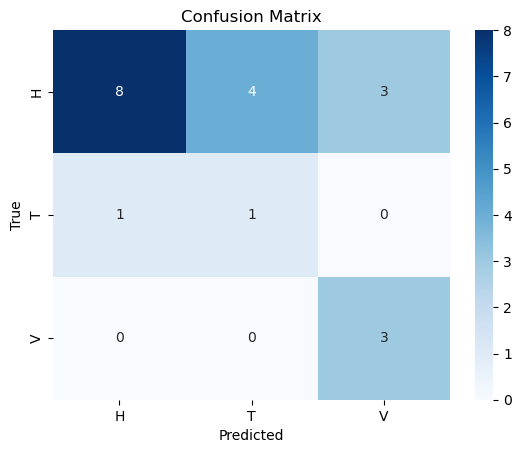

                                Feature  Importance
5       away_club_position_label_Europe    0.146615
6   away_club_position_label_Relegation    0.134588
3   home_club_position_label_Relegation    0.131501
1       home_club_position_label_Europe    0.130935
13              attendance_label_Medium    0.111453
12               attendance_label_Large    0.079739
15                         hosting_Away    0.073101
16                         hosting_Home    0.064516
2      home_club_position_label_Nothing    0.040957
11        away_club_formation_label_4_D    0.027595


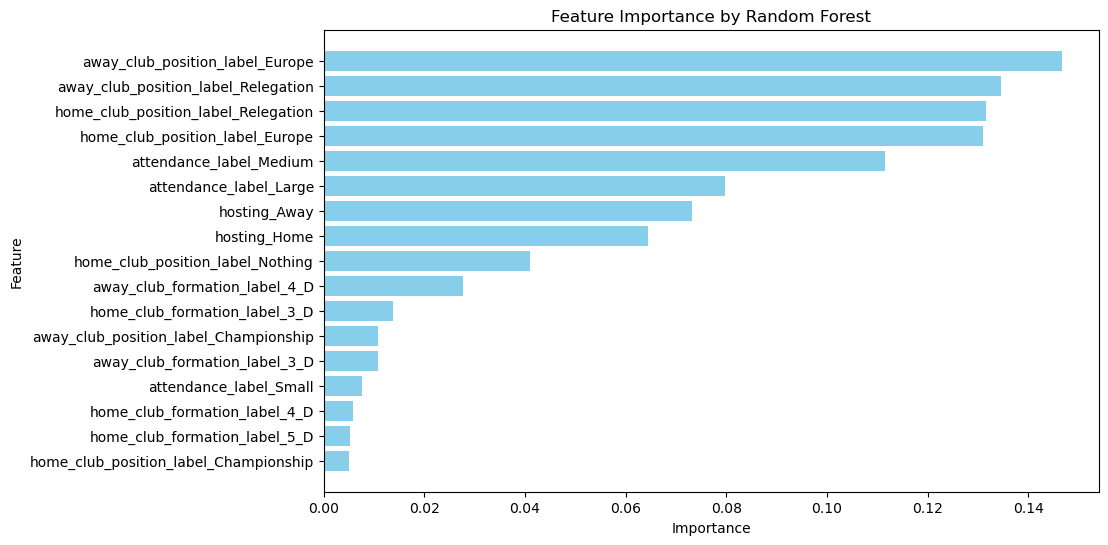

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

def assign_attendance_label(attendance):
    if attendance > 45000:   
        return 'Large'
    elif 20000 <= attendance < 45000:  
        return 'Medium'
    elif attendance < 20000:  
        return 'Small'
    else:
        return None

def assign_formation_label(formation):

    if formation.startswith('4'):   
        return '4_D'
    elif formation.startswith('3'):  
        return '3_D'
    elif formation.startswith('5'):  
        return '5_D'
    else:
        return None

def assign_position_label(position):
    if position <= 2:
        return 'Championship'
    elif 3 <= position <= 9:
        return 'Europe'
    elif 10 <= position <= 14:
        return 'Nothing'
    elif 15 <= position <= 20:
        return 'Relegation'
    else:
        return None


club_data = pd.read_csv('csv/clubs.csv')
club_games_data = pd.read_csv('csv/club_games.csv')
games_data = pd.read_csv('csv/games.csv')
games_data['home_club_formation'] = games_data['home_club_formation'].str.replace(r'^\D+', '', regex=True)
games_data['away_club_formation'] = games_data['away_club_formation'].str.replace(r'^\D+', '', regex=True)



season = int(input("Ingresa la temporada a buscar (2023 para la 23/24, 2022 para 22/23): "))
matchDay = 19 

filtered_games = games_data[(games_data['season'] == season) & 
                            (games_data['competition_id'] == 'GB1') & 
                            (games_data['competition_type'] == 'domestic_league')].copy()

filtered_games['round'] = filtered_games['round'].str.replace(r'\D+', '', regex=True).astype(int)
selected_games = filtered_games[filtered_games['round'] == matchDay]

filtered_teams = pd.DataFrame({
    'club_names': pd.concat([filtered_games['home_club_name'], filtered_games['away_club_name']], ignore_index=True)
}).drop_duplicates(subset='club_names', keep='first')

selected_index = int(input("Ingresa el índice del equipo que deseas seleccionar: "))
selected_team = filtered_teams.loc[selected_index]

if not selected_team.empty:
    team_name = selected_team['club_names']
    team_id = filtered_games.loc[filtered_games['home_club_name'] == team_name, 'home_club_id'].drop_duplicates(keep='first').iloc[0]
    print(f"Nombre del equipo: {team_name} y su id: {team_id} \n")
else:
    print("No se encontró un equipo con el índice proporcionado.\n")


filtered_games['result'] = filtered_games.apply(lambda row: 'H' if row['home_club_goals'] > row['away_club_goals'] else 
                                                ('T' if row['home_club_goals'] == row['away_club_goals'] else 'V'), axis=1)

filtered_games['home_club_position_label'] = filtered_games['home_club_position'].apply(assign_position_label)
filtered_games['away_club_position_label'] = filtered_games['away_club_position'].apply(assign_position_label)
filtered_games['home_club_formation_label'] = filtered_games['home_club_formation'].apply(assign_formation_label)
filtered_games['away_club_formation_label'] = filtered_games['away_club_formation'].apply(assign_formation_label)
filtered_games['attendance_label'] = filtered_games['attendance'].apply(assign_attendance_label)

team_home_games = filtered_games[filtered_games['home_club_name'] == team_name].merge(
    club_games_data[(club_games_data['hosting'] == 'Home') & (club_games_data['club_id'] == team_id)],
    on='game_id', how='inner')

team_away_games = filtered_games[filtered_games['away_club_name'] == team_name].merge(
    club_games_data[(club_games_data['hosting'] == 'Away') & (club_games_data['club_id'] == team_id)],
    on='game_id', how='inner')

columns_to_keep = ['game_id', 'home_club_name', 'away_club_name', 'home_club_id', 'away_club_id', 'round', 'attendance_label',
                   'home_club_position_label', 'away_club_position_label', 'home_club_formation_label', 'away_club_formation_label',
                   'home_club_goals', 'away_club_goals', 'hosting', 'is_win', 'result']

team_home_games = team_home_games[columns_to_keep]
team_away_games = team_away_games[columns_to_keep]
filtered_games = pd.concat([team_home_games, team_away_games])

filtered_games = filtered_games.sort_values(by='round').reset_index(drop=True)

features = ['home_club_position_label', 'away_club_position_label', 'home_club_formation_label', 
            'away_club_formation_label', 'attendance_label', 'hosting']

train_data = filtered_games[filtered_games['round'] < matchDay]
X_train = train_data[features]
y_train = train_data['result']

encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
X_train_encoded = encoder.fit_transform(X_train)

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

model = GridSearchCV(RandomForestClassifier(class_weight='balanced', random_state=42), param_grid, cv=5, scoring='accuracy')
model.fit(X_train_encoded, y_train)
best_model = model.best_estimator_
print("Mejores hiperparámetros encontrados:", model.best_params_)

test_data = filtered_games[((filtered_games['home_club_id'] == team_id) | (filtered_games['away_club_id'] == team_id)) & 
                           (filtered_games['round'] >= matchDay)][features]
test_data_result = filtered_games[((filtered_games['home_club_id'] == team_id) | (filtered_games['away_club_id'] == team_id)) & 
                                   (filtered_games['round'] >= matchDay)]['result']
X_test_encoded = encoder.transform(test_data)

if not test_data.empty:
    y_pred = best_model.predict(X_test_encoded)
    y_test = test_data_result.values

    print(f"\nPredicciones para los partidos de {team_name} a partir de la jornada {matchDay}:")
    for idx, pred in enumerate(y_pred):
        row = test_data.iloc[idx]
        if row['hosting'] == 'Home':
            if pred == 'H':
                print(f"Partido {idx + 1}: Resultado predicho: {team_name} gana como local")
            elif pred == 'V':
                print(f"Partido {idx + 1}: Resultado predicho: {team_name} pierde como local")
            else:
                print(f"Partido {idx + 1}: Resultado predicho: {team_name} empata como local")    
        elif row['hosting'] == 'Away':
            if pred == 'H':
                print(f"Partido {idx + 1}: Resultado predicho: {team_name} pierde como visitante")
            elif pred == 'V':
                print(f"Partido {idx + 1}: Resultado predicho: {team_name} gana como visitante")
            else:
                print(f"Partido {idx + 1}: Resultado predicho: {team_name} empata como visitante")    
        else: 
            print('Fallo en la detección del local')

    print("\nValores predichos en el conjunto de prueba (y_pred):")
    print(pd.DataFrame(y_pred, columns=['y_pred']))

    print("\nValores verdaderos en el conjunto de prueba (y_test):")
    print(pd.DataFrame(y_test, columns=['y_test']))

    print("\nReporte de Clasificación en el conjunto de prueba:")
    print(classification_report(y_test, y_pred))

    print("\nPrecisión en el conjunto de prueba:")
    print(f"Accuracy en prueba: {accuracy_score(y_test, y_pred):.2f}")

    cm = confusion_matrix(y_test, y_pred, labels=best_model.classes_)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=best_model.classes_, yticklabels=best_model.classes_)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    
    feature_names = encoder.get_feature_names_out(X_train.columns)
    importances = best_model.feature_importances_
    feature_importance = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    }).sort_values(by='Importance', ascending=False)

    print(feature_importance.head(10))
    plt.figure(figsize=(10, 6))
    plt.barh(feature_importance['Feature'], feature_importance['Importance'], color='skyblue')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.title('Feature Importance by Random Forest')
    plt.gca().invert_yaxis() 
    plt.show()

else:
    print(f"No hay partidos disponibles para {team_name} a partir de la jornada {matchDay}")


Nombre del equipo: Manchester United Football Club y su id: 985 



c:\Users\ivizq\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


Mejores hiperparámetros encontrados: {'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 50}

Predicciones para los partidos de Manchester United Football Club a partir de la jornada 28:
Partido 1: Resultado predicho: Manchester United Football Club pierde como visitante por menos o igual a dos goles de diferencia
Partido 2: Resultado predicho: Manchester United Football Club gana como visitante por dos goles de diferencia
Partido 3: Resultado predicho: Manchester United Football Club gana como local por dos goles de diferencia
Partido 4: Resultado predicho: Manchester United Football Club pierde como visitante por menos o igual a dos goles de diferencia
Partido 5: Resultado predicho: Manchester United Football Club gana como local por menos o igual a dos goles de diferencia
Partido 6: Resultado predicho: Manchester United Football Club gana como visitante por dos goles de diferencia
Partido 7: Resultado predicho: Manchester United Football Club gana como

c:\Users\ivizq\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\ivizq\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\ivizq\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


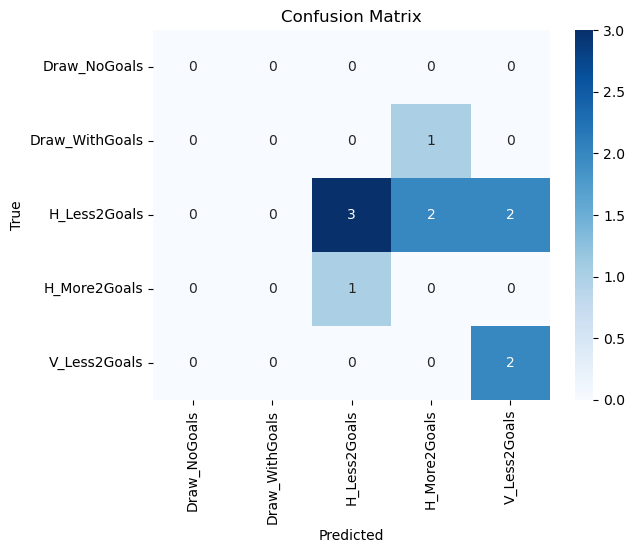

                                Feature  Importance
14               attendance_label_Large    0.241595
1       home_club_position_label_Europe    0.172532
5       away_club_position_label_Europe    0.169828
17                         hosting_Away    0.140251
15              attendance_label_Medium    0.083997
7   away_club_position_label_Relegation    0.078966
18                         hosting_Home    0.065146
2      home_club_position_label_Nothing    0.047686
12        away_club_formation_label_4_D    0.000000
16               attendance_label_Small    0.000000


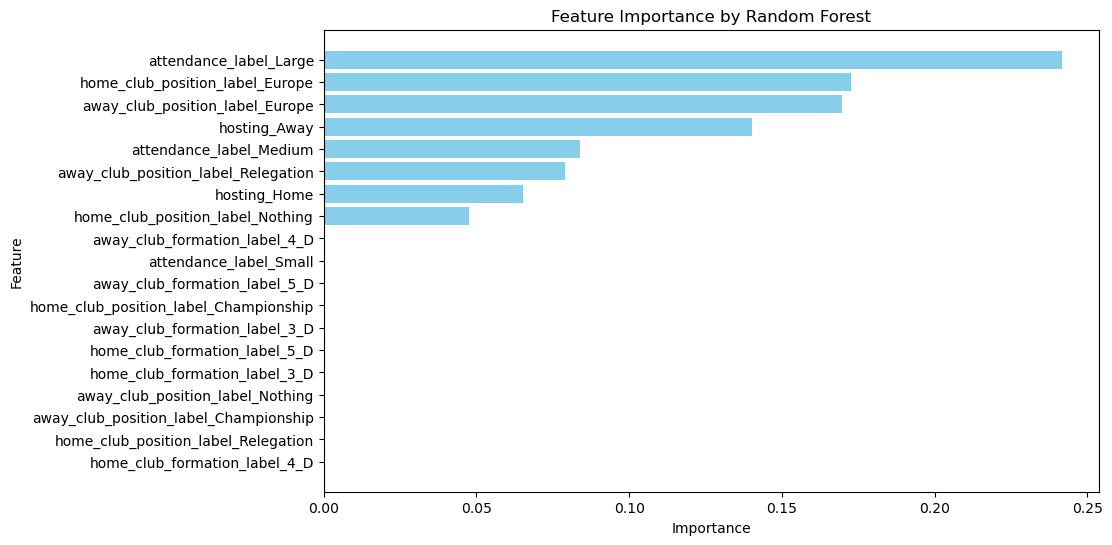

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Funciones de asignación de etiquetas (sin cambios)
def assign_attendance_label(attendance):
    if attendance > 45000:   # Si es un estadio grande
        return 'Large'
    elif 20000 <= attendance < 45000:  # Si es un estadio mediano
        return 'Medium'
    elif attendance < 20000:  # Si es un estadio pequeño
        return 'Small'
    else:
        return None

def assign_formation_label(formation):
    if formation.startswith('4'):   # Si es una formación con 4 defensas
        return '4_D'
    elif formation.startswith('3'):  # Si es una formación con 3 defensas
        return '3_D'
    elif formation.startswith('5'):  # Si es una formación con 5 defensas
        return '5_D'
    else:
        return None

def assign_position_label(position):
    if position <= 2:
        return 'Championship'
    elif 3 <= position <= 9:
        return 'Europe'
    elif 10 <= position <= 14:
        return 'Nothing'
    elif 15 <= position <= 20:
        return 'Relegation'
    else:
        return None

# Cargar datos
club_data = pd.read_csv('csv/clubs.csv')
club_games_data = pd.read_csv('csv/club_games.csv')
games_data = pd.read_csv('csv/games.csv')
games_data['home_club_formation'] = games_data['home_club_formation'].str.replace(r'^\D+', '', regex=True)
games_data['away_club_formation'] = games_data['away_club_formation'].str.replace(r'^\D+', '', regex=True)

# Filtrar datos
season = int(input("Ingresa la temporada a buscar (2023 para la 23/24, 2022 para 22/23): "))
matchDay = 28 

filtered_games = games_data[(games_data['season'] == season) & 
                            (games_data['competition_id'] == 'GB1') & 
                            (games_data['competition_type'] == 'domestic_league')].copy()

filtered_games['round'] = filtered_games['round'].str.replace(r'\D+', '', regex=True).astype(int)
selected_games = filtered_games[filtered_games['round'] == matchDay]

filtered_teams = pd.DataFrame({
    'club_names': pd.concat([filtered_games['home_club_name'], filtered_games['away_club_name']], ignore_index=True)
}).drop_duplicates(subset='club_names', keep='first')

selected_index = int(input("Ingresa el índice del equipo que deseas seleccionar: "))
selected_team = filtered_teams.loc[selected_index]

if not selected_team.empty:
    team_name = selected_team['club_names']
    team_id = filtered_games.loc[filtered_games['home_club_name'] == team_name, 'home_club_id'].drop_duplicates(keep='first').iloc[0]
    print(f"Nombre del equipo: {team_name} y su id: {team_id} \n")
else:
    print("No se encontró un equipo con el índice proporcionado.\n")

# Asignación de etiquetas
filtered_games['result'] = filtered_games.apply(
    lambda row: (
        'Draw_NoGoals' if row['home_club_goals'] == row['away_club_goals'] and row['home_club_goals'] == 0 else
        'Draw_WithGoals' if row['home_club_goals'] == row['away_club_goals'] and row['home_club_goals'] > 0 else
        'H_More2Goals' if abs(row['home_club_goals'] - row['away_club_goals']) > 2 and row['home_club_goals'] > row['away_club_goals'] else
        'V_More2Goals' if abs(row['home_club_goals'] - row['away_club_goals']) > 2 and row['away_club_goals'] > row['home_club_goals'] else
        'H_Less2Goals' if row['home_club_goals'] > row['away_club_goals'] else
        'V_Less2Goals'
    ), axis=1)

filtered_games['home_club_position_label'] = filtered_games['home_club_position'].apply(assign_position_label)
filtered_games['away_club_position_label'] = filtered_games['away_club_position'].apply(assign_position_label)
filtered_games['home_club_formation_label'] = filtered_games['home_club_formation'].apply(assign_formation_label)
filtered_games['away_club_formation_label'] = filtered_games['away_club_formation'].apply(assign_formation_label)
filtered_games['attendance_label'] = filtered_games['attendance'].apply(assign_attendance_label)

# División de datos en locales y visitantes
team_home_games = filtered_games[filtered_games['home_club_name'] == team_name].merge(
    club_games_data[(club_games_data['hosting'] == 'Home') & (club_games_data['club_id'] == team_id)],
    on='game_id', how='inner')

team_away_games = filtered_games[filtered_games['away_club_name'] == team_name].merge(
    club_games_data[(club_games_data['hosting'] == 'Away') & (club_games_data['club_id'] == team_id)],
    on='game_id', how='inner')

columns_to_keep = ['game_id', 'home_club_name', 'away_club_name', 'home_club_id', 'away_club_id', 'round', 'attendance_label',
                   'home_club_position_label', 'away_club_position_label', 'home_club_formation_label', 'away_club_formation_label',
                   'home_club_goals', 'away_club_goals', 'hosting', 'is_win', 'result']

team_home_games = team_home_games[columns_to_keep]
team_away_games = team_away_games[columns_to_keep]
filtered_games = pd.concat([team_home_games, team_away_games])

filtered_games = filtered_games.sort_values(by='round').reset_index(drop=True)

# Selección de características
features = ['home_club_position_label', 'away_club_position_label', 'home_club_formation_label', 
            'away_club_formation_label', 'attendance_label', 'hosting']

train_data = filtered_games[filtered_games['round'] < matchDay]
X_train = train_data[features]
y_train = train_data['result']

# Codificación de las características
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
X_train_encoded = encoder.fit_transform(X_train)

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

model = GridSearchCV(RandomForestClassifier(class_weight='balanced', random_state=42), param_grid, cv=5, scoring='accuracy')
model.fit(X_train_encoded, y_train)
best_model = model.best_estimator_
print("Mejores hiperparámetros encontrados:", model.best_params_)

# Predicción en datos de prueba
test_data = filtered_games[((filtered_games['home_club_id'] == team_id) | (filtered_games['away_club_id'] == team_id)) & 
                           (filtered_games['round'] >= matchDay)][features]
test_data_result = filtered_games[((filtered_games['home_club_id'] == team_id) | (filtered_games['away_club_id'] == team_id)) & 
                                   (filtered_games['round'] >= matchDay)]['result']
X_test_encoded = encoder.transform(test_data)

if not test_data.empty:
    y_pred = best_model.predict(X_test_encoded)
    y_test = test_data_result.values

    print(f"\nPredicciones para los partidos de {team_name} a partir de la jornada {matchDay}:")
    for idx, pred in enumerate(y_pred):
        row = test_data.iloc[idx]
        if row['hosting'] == 'Home':
            if pred == 'H_More2Goals':
                print(f"Partido {idx + 1}: Resultado predicho: {team_name} gana como local por dos goles de diferencia")
            elif pred == 'V_More2Goals':
                print(f"Partido {idx + 1}: Resultado predicho: {team_name} pierde como local por dos goles de diferencia")
            elif pred == 'H_Less2Goals':
                print(f"Partido {idx + 1}: Resultado predicho: {team_name} gana como local por menos o igual a dos goles de diferencia")
            elif pred == 'V_Less2Goals':
                print(f"Partido {idx + 1}: Resultado predicho: {team_name} pierde como local por menos o igual a dos goles de diferencia")
            elif pred == 'Draw_NoGoals':
                print(f"Partido {idx + 1}: Resultado predicho: {team_name} empata como local sin goles")
            else:
                print(f"Partido {idx + 1}: Resultado predicho: {team_name} empata como local con goles")    
        elif row['hosting'] == 'Away':
            if pred == 'H_More2Goals':
                print(f"Partido {idx + 1}: Resultado predicho: {team_name} gana como visitante por dos goles de diferencia")
            elif pred == 'V_More2Goals':
                print(f"Partido {idx + 1}: Resultado predicho: {team_name} pierde como visitante por dos goles de diferencia")
            elif pred == 'H_Less2Goals':
                print(f"Partido {idx + 1}: Resultado predicho: {team_name} gana como visitante por menos o igual a dos goles de diferencia")
            elif pred == 'V_Less2Goals':
                print(f"Partido {idx + 1}: Resultado predicho: {team_name} pierde como visitante por menos o igual a dos goles de diferencia")
            elif pred == 'Draw_NoGoals':
                print(f"Partido {idx + 1}: Resultado predicho: {team_name} empata como visitante sin goles")
            else:
                print(f"Partido {idx + 1}: Resultado predicho: {team_name} empata como visitante con goles")      
        else: 
            print('Fallo en la detección del local')

    # Mostrar las predicciones y los valores verdaderos del conjunto de prueba
    print("\nValores predichos en el conjunto de prueba (y_pred):")
    print(pd.DataFrame(y_pred, columns=['y_pred']))

    print("\nValores verdaderos en el conjunto de prueba (y_test):")
    print(pd.DataFrame(y_test, columns=['y_test']))

    # Métricas de evaluación en el conjunto de prueba
    print("\nReporte de Clasificación en el conjunto de prueba:")
    print(classification_report(y_test, y_pred))

    print("\nPrecisión en el conjunto de prueba:")
    print(f"Accuracy en prueba: {accuracy_score(y_test, y_pred):.2f}")

    # Matriz de confusión
    cm = confusion_matrix(y_test, y_pred, labels=best_model.classes_)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=best_model.classes_, yticklabels=best_model.classes_)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    # Importancia de características
    feature_names = encoder.get_feature_names_out(X_train.columns)
    importances = best_model.feature_importances_
    feature_importance = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    }).sort_values(by='Importance', ascending=False)

    print(feature_importance.head(10))
    plt.figure(figsize=(10, 6))
    plt.barh(feature_importance['Feature'], feature_importance['Importance'], color='skyblue')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.title('Feature Importance by Random Forest')
    plt.gca().invert_yaxis()  # Invertir el eje y para que las características más importantes estén arriba
    plt.show()

else:
    print(f"No hay partidos disponibles para {team_name} a partir de la jornada {matchDay}")
